In [5]:
!pip install scrapy
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 264 kB 35.8 MB/s 
     |████████████████████████████████| 55 kB 4.8 MB/s 
     |████████████████████████████████| 93 kB 2.3 MB/s 
     |████████████████████████████████| 251 kB 76.1 MB/s 
     |████████████████████████████████| 4.1 MB 65.8 MB/s 
     |████████████████████████████████| 47 kB 5.9 MB/s 
     |████████████████████████████████| 3.1 MB 54.0 MB/s 
     |████████████████████████████████| 74 kB 3.8 MB/s 
  Created wheel for PyDispatcher: filename=PyDispatcher-2.0.5-py3-none-any.whl size=11516 sha256=f4b3990cde278082a3af1f6174814476886295aee5c9cb18aa2c83c92353227a
  Stored in directory: /root/.cache/pip/wheels/2d/18/21/3c6a732eaa69a339198e08bb63b7da2c45933a3428b29ec454
Successfully built PyDispatcher
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import requests

In [7]:
from scrapy.http import TextResponse

In [16]:
def send_request_to_url(site_url):
  py_res = requests.get(site_url)

  scrapy_res = TextResponse(py_res.url, body=py_res.text, encoding='utf-8')

  return scrapy_res

In [31]:
import time

def scrape_website():
  page_str = ''
  quotations = []

  while(True):
    scrapy_res = send_request_to_url(
        'http://quotes.toscrape.com/' + page_str)
    time.sleep(1)

    for sel in scrapy_res.xpath('//div[@class="quote"]'):
      quotation_dict = {}

      quotation_dict['quote'] = (sel
                                 .xpath('.//span[@class="text"]/text()').extract_first())
      
      quotation_dict['author'] = (sel
                                  .xpath('.//small[@class="author"]/text()').extract_first())
      
      quotation_dict['tags'] = ('; '.join(sel
                                          .xpath('.//a[@class="tag"]/text()').extract()))
      
      quotations.append(quotation_dict)

      page_str = scrapy_res.xpath(
          '//li[@class="next"]/a/@href').extract_first()
    
    if not page_str:
      return quotations


          

In [32]:
import pandas as pd

def save_quotations_to_cvs(quotations):

  quotations_df = pd.DataFrame(quotations)

  display(quotations_df.head())

  quotations_df.to_csv('quotations.cvs', index=False)

In [33]:
def generate_tags_list(quotations):

  tags_list = []
  for q in quotations:
    q_tags = q['tags'].split(';')
    q_tags = map(lambda x: x.strip(), q_tags)
    tags_list.extend(q_tags)

    tags_list = filter(lambda x: x!='', tags_list)

    return tags_list

In [34]:
def get_top_n_tags(tags_list, n):
  occur_dict = dict((x, tags_list.count(x)) for x in set(tags_list))

  occur_dict = {
      k: v for k,v in sorted(
          occur_dict.items(), 
          key = lambda item: item[1],
          reverse = True
      )[:n]
        }
  return occur_dict

In [35]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

def generate_word_cloud(top_tags, tags_list):

  text = ' '.join(list(filter(lambda x: x in top_tags, tags_list)))

  wordcloud = WordCloud(background_color="white").generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [36]:
def run_script():
  quotations = scrape_website()
  save_quotations_to_cvs(quotations)
  tags_list = list(generate_tags_list(quotations))

  top_15_tags = get_top_n_tags(tags_list, 15)
  generate_word_cloud(top_15_tags, tags_list)

,quote,author,tags
0,“The world as we have created it is a process ...,Albert Einstein,change; deep-thoughts; thinking; world
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,abilities; choices
2,“There are only two ways to live your life. On...,Albert Einstein,inspirational; life; live; miracle; miracles
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,aliteracy; books; classic; humor
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,be-yourself; inspirational


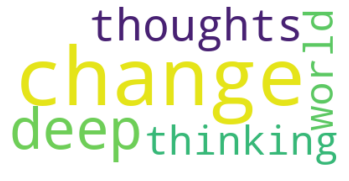

In [39]:
run_script()